# Chapter 08

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

## Exercises

### R-8.1

The following questions refer to the tree of Figure 8.3.

#### (a) Which node is the root?

`/user/rt/courses/`

#### (b) What are the internal nodes?

*Internal* nodes are nodes which have one or more children.

* `/user/rt/courses/`
* `cs016/`
* `cs252/`
* `homeworks/`
* `programs/`
* `projects/`
* `papers/`
* `demos/`

#### (c) How many descendants does node `cs016/` have?

There are 10 descendants, `cs016/`, `grades`, `homeworks/`, `programs/`, `hw1`, `hw2`, `hw3`, `pr1`, `pr2`, `pr3`

#### (d) How many ancestors does node `cs016/` have?

There are ***two*** ancestors. (`cs016/` and `/user/rt/courses/`)

Be aware that by the definition of ***ancestor***, a node is an ancestor of itself.

>A node $u$ is an ***ancestor*** of a node $v$ if $u = v$ or $u$ is an ancestor of the parent of $v$.

#### (e) What are the siblings of node `homeworks/`?

`grades` and `programs/`

#### (f) Which nodes are in the subtree rooted at node `projects/`?

6 nodes: `projects/`, `papers/`, `demos/`, `buylow`, `sellhigh`, `market`

#### (g) What is the `depth` of node `papers/`?

3

#### (h) What is the height of the tree?

4

## R-8.3 & C-8.33

#### Let $T$ be a (possibly improper) binary tree with $n$ nodes, and let $D$ be the sum of the depths of all the external nodes of $T$. Describe a configuration for $T$ such that $D$ is $\Omega(n^2)$. Such a tree would be the worst case for the asymptotic running time of method `_height1` (Code Fragment 8.4).

It tree is an improper tree like:

![improper_tree](../images/improper_tree.png)

`height1`'s running time is $O(n + \sum_{p \in L} (d_p + 1))$.

The first term $n$ accounts for the number of nodes for comparing maximum values. And the second summation term depends on tree structures. If tree structure is like above, the number of nodes at leaf is proportional to $n/2$, and depth $d_p$ also proportional to $n/2$, which yields the worst case running time to be $O(n^2)$. This is very inefficient since it needs to query all nodes in a tree. (Each node will be visited multiple times!)

### R-8.4

#### What is the running time of a call to `T._height2(p)` when called on a position `p` distinct from the root of `T`? (See Code Fragment 8.5)

> Code Fragment 8.5
> ```python
> def _height2(self, p):
>      """Return the height of the subtree rooted at Position p."""
>    if self.is_leaf(p):
>        return 0
>    else:
>        return 1 + max(self._height2(c) for c in self.children(p))
> ```

The worst-case time will be $O(n)$. (All nodes form a single branch)

### R-8.8

#### Answer the following questions so as to justify Proposition 8.8.

#### (a) What is the minimum number of external nodes for a proper binary tree with height $h$? Justify your answer.

* For $h=0$: external nodes: 1
* For $h=1$: external nodes: 2
* For $h=2$: external nodes: 3
* For $h=3$: external nodes: 4
* For $h=4$: external nodes: 5

...

Therefore, the number of minimum external nodes for a proper binary tree is $h+1$.

#### (b) What is the maximum number of external nodes for a proper binary tree with height $h$? Justify tour answer.

* For $h=0$: external nodes: 1
* For $h=1$: external nodes: 2
* For $h=2$: external nodes: 4
* For $h=3$: external nodes: 8
* For $h=4$: external nodes: 16

...

Therefore, the number of maximum external nodes for a proper binary tree is $2^h$

#### (c) Let $T$ be a proper binary tree with height $h$ and $n$ nodes. Show that 

$$\log(n+1) - 1 \leq h \leq (n-1)/2$$

From the answer of (a),

The total number of nodes with minimum external node case: $n \geq 2h +1 (h \geq 2)$

Therefore, $h \leq (n-1)/2$

From the answer of (b),
The total number of nodes with maximum external node case: $n \leq 2^{h+1} - 1$

Therefore, $\log_2(n+1) - 1 \leq h$

#### (d) For which values of $n$ and $h$ can the above lower and upper bound on $h$ be attained with equality?

Answered at (c)

### R-8.10

#### Give a direct implementation of the `num_children` method within the class `BinaryTree`.

In [2]:
from abc import ABC, abstractmethod

class Tree(ABC):
    """Abstract base class representing a tree structure."""
    
    class Position(ABC):
        """An abstraction representing the location of a single element."""
        
        @abstractmethod
        def element(self):
            """Return the element stored at this Position."""
            pass
        
        @abstractmethod
        def __eq__(self, other):
            """Return True if other Position represents the same location."""
            pass
        
        def __ne__(self, other):
            """Return True if other does not represent the same location."""
            return not (self == other)

    @abstractmethod
    def root(self):
        """Return Position representing the tree's root (or None if empty)."""
        pass
    
    @abstractmethod
    def parent(self, p):
        """Return Position representing p's parent (or None if p is root)."""
        pass
    
    @abstractmethod
    def num_children(self, p):
        """Return the number of children that Position p has."""
        pass
    
    @abstractmethod
    def children(self, p):
        """Generate an iteration of Positions representing p's children."""
        pass
    
    @abstractmethod
    def __len__(self):
        """Return the total number of elements in the tree."""
        pass
    
    def __iter__(self):
        for p in self.positions():
            yield p.element()
    
    def is_root(self, p):
        """Return True if Position p represents the root of the tree."""
        return self.root() == p
    
    def is_leaf(self, p):
        """Return True if Position p does not have any children."""
        return self.num_children(p) == 0
    
    def is_empty(self):
        """Return True if the tree is empty."""
        return len(self) == 0
    
    def depth(self, p):
        if self.is_root(p):
            return 0
        else:
            return 1 + self.depth(self.parent(p))
    
    def _height1(self):
        return max(self.depth(p) for p in self.positions if self.is_leaf(p))
        
    def _height2(self, p):
        if self.is_leaf(p):
            return 0
        else:
            return 1 + max(self._hegiht2(c) for c in self.children(p))
    
    def height(self, p=None):
        if p is None:
            p = self.root()
        return self._height2(p)

In [3]:
class BinaryTree(Tree):
    """Abstract base class representing a binary tree structure."""
    
    @abstractmethod
    def left(self, p):
        """Return a Position representing p's left child.
        
        Return None if p does not have a left child.
        """
        pass
    
    @abstractmethod
    def right(self, p):
        """Return a Position representing p's right child.
        
        Return None if p does not have a right child.
        """
        pass
    
    @property
    def num_children(self, p):
        num_ch = 0
        if self.left(p):
            num_ch += 1
        if self.right(p):
            num_ch += 1
        return num_ch
    
    def sibling(self, p):
        """Return a Position representing p's sibling (or None if no sibling)."""
        parent = self.parent(p)
        if parent is None:
            return None
        else:
            if p == self.left(parent):
                return self.right(parent)
            else:
                return self.left(parent)
            
    def children(self, p):
        """Generate an iteration of Positions representing p's children."""
        if self.left(p) is not None:
            yield self.left(p)
        
        if self.right(p) is not None:
            yield self.right(p)

In [4]:
class LinkedBinaryTree(BinaryTree):
    """Linked representation of a binary tree structure."""

    class _Node:
        __slots__ = '_element', '_parent', '_left', '_right'

        def __init__(self, element, parent=None, left=None, right=None):
            self._element = element
            self._parent = parent
            self._left = left
            self._right = right

    
    class Position(BinaryTree.Position):
        """An abstraction representing the location of a single element."""

        def __init__(self, container, node):
            """Constructor should not be invoked by user."""
            self._container = container
            self._node = node

        def element(self):
            return self._node._element

        
        def __eq__(self, other):
            return type(other) is type(self) and other._node is self._node

    def _validate(self, p):
        """Return associated node, if position is valid."""
        if not isinstance(p, self.Position):
            raise TypeError('p must be proper Position type')

        if p._container is not self:
            raise ValueError('p does not belong to this container')

        if p._node._parent is p._node:
            raise ValueError('p is no longer valid')
        return p._node

    def _make_position(self, node):
        """Return Position instance for given node (or None if no node)."""
        return self.Position(self, node) if node is not None else None


    def __init__(self):
        """Create an intially empty binary tree."""
        self._root = None
        self._size = 0
        self._positions = []
    

    def __len__(self):
        """Return the total number of elements in the tree."""
        return self._size

    def root(self):
        """Return the root Position of the tree (or None if tree is empty)."""
        return self._make_position(self._root)

    @property
    def positions(self):
        return self._positions
    
    def parent(self, p):
        """Return the Position of p's parent(or None if p is root)."""
        node = self._validate(p)
        return self._make_position(node._parent)


    def left(self, p):
        """Return the Position of p's left child(or None if no left child)."""
        node = self._validate(p)
        return self._make_position(node._left)

    def right(self, p):
        """Return the Position of p's left child(or None if no left child)."""
        node = self._validate(p)
        return self._make_position(node._right)

    def num_children(self, p):
        """Return the number of children of Position p."""
        node = self._validate(p)
        count = 0
        if node._left is not None:
            count += 1
        if node._right is not None:
            count += 1
        return count

    def _add_root(self, e):
        """Place element e at the root of an empty tree and return new Position.

        Raise ValueError if tree nonempty.
        """

        if self._root is not None: raise ValueError('Root exists')
        self._size = 1
        self._root = self._Node(e)
        pos = self._make_position(self._root)
        self._positions.append(pos)
        return pos

    def _add_left(self, p, e):
        """Create a new left child for Position p, storing element e.
        
        Return the Position of new node
        Raise ValueError if Position p is invalidor p already has a left child.
        """

        node = self._validate(p)
        if node._right is not None: raise ValueError('Left child exists')
        self._size += 1
        node._left = self._Node(e, node)
        pos = self._make_position(node._left)
        self._positions.append(pos)
        return pos 

    def _add_right(self, p, e):
        """Create a new right child for Position p, storing element e.
        
        Return the Position of new node
        Raise ValueError if Position p is invalid or p already has a right child.
        """

        node = self._validate(p)
        if node._right is not None: raise ValueError('Right child exists')
        self._size += 1
        node._right = self._Node(e, node)
        pos = self._make_position(node._right)
        self._positions.append(pos)
        return pos


    def _replace(self, p, e):
        """Replace the element at position p with e, and return old element."""
        node = self._validate(p)
        old = node._element
        node._element = e
        return old

    def _delete(self, p):
        """Delete the node at Position p, and replace it with its child, if any..git/

        Return the element that had been stored at Position p
        Raise ValueError if Position p is invalid or p has two children.
        """

        node = self._validate(p)
        if self.num_children(p) == 2: raise ValueError('p has two children')
        child = node._left if node._left else node._right
        if child is not None:
            child._parent = node._parent
        if node is self._root:
            self._root = child
        else:
            parent = node._parent
            if node is parent._left:
                parent._left = child
            else:
                parent._right = child
        
        self._positions.remove(p)
        self._size -= 1
        node._parent = node
        return node._element

    def _attach(self, p, t1, t2):
        """Attach trees t1 and t2 as left and right subtrees of external p."""
        node = self._validate(p)
        if not self.is_leaf(p): raise ValueError('position must be leaf')
        if not type(self) is type(t1) is type(t2):
            raise TypeError('Tree types must match')
        self._size += len(t1) + len(t2)
        if not t1.is_empty():
            t1._root._parent = node
            node._left = t1._root
            t1._root = None
            t1._size = 0
        if not t2.is_empty():
            t2._root._parent = node
            node._right = t2.root
            t2._root = None
            t2._size = 0


In [5]:
balanced_tree = LinkedBinaryTree()
balanced_tree._add_root("root")

In [6]:
balanced_tree.num_children(balanced_tree.root())

0

In [7]:
balanced_tree._add_left(balanced_tree.root(), "left")

In [8]:
balanced_tree.num_children(balanced_tree.root())

1

In [9]:
balanced_tree._add_right(balanced_tree.root(), "right")

In [10]:
balanced_tree.num_children(balanced_tree.root())

2

### R-8.15

#### The `LinkedBinaryTree` class provides only nonpublic versions of the update methods discussed on page 319. Implement a simple subclass named `MutableLinkedBinaryTree` that provides public wrapper functions for each of the inheirted nonpublic update methods.

In [11]:
class MutableLinkedBinaryTree(LinkedBinaryTree):
    """
    Provides public wrapper functions for each of the inherited nonpublic update methods.
    """
    
    def add_root(self, e):
        return self._add_root(e)
        
    def add_left(self, p, e):
        return self._add_left(p, e)
    
    def add_right(self, p, e):
        return self._add_right(p, e)
        
    def replace(self, p, e):
        return self._replace(p, e)
    
    def delete(self, p):
        return self._delete(p)
        
    def attach(self, p, T1, T2):
        return self.attach(p, T1, T2)

In [12]:
balanced_tree = MutableLinkedBinaryTree()

In [13]:
balanced_tree.add_root("root")

In [14]:
try:
    balanced_tree._add_root("root")
except Exception as e:
    print(e)

Root exists


In [15]:
balanced_tree.root().element()

'root'

### C-8.32

#### Let $T$ be a (not necessarily proper) binary tree with $n$ nodes, and let $D$ be the sum of the depths of all the external nodes of $T$. Show that if $T$ has the minimum number of external nodes possible, then $D$ is $O(n)$ and if $T$ has the maximum number of external nodes possible, then $D$ is $O(n \log n)$.

If $T$ has the minimum number of external nodes possible, then $D$ is $O(n)$ *when a tree just composes a single branch*. However, if $T$ has the maximum number of external nodes, the number of leaves will grow with proportional to $n/2$, and the depth will grow as: $\log_2(n)$. Therefore, $D$ is $O(n\log n)$.

### C-8.34

#### For a tree $T$, let $n_I$ denote the number of its internal nodes, and let $n_E$ denote the number of its external nodes. Show that if every internal node in $T$ has exactly 3 children, then $n_E = 2n_I + 1$.

If every internal node have three children, then the number of nodes at depth $d$ is represented as: $3^d$.

In this scheme, if there is a tree with depth $d$,

$n_I = \sum_{i=0}^{d-1}3^i = 1 + \sum_{i=1}^{d-1}3^i = 1 + \frac{3 \cdot (3^{d-1} - 1)}{3 - 1} = 1 + \frac{3^d - 3}{2} = 1 + \frac{n_E -3}{2}$

Therefore, $2n_I - 2 = n_E - 3$, which eventually yields, $n_E = 2n_I + 1$.

### C-8.40

#### We can simplify parts of our `LinkedBinaryTree` implementation if we make use of a single sentinel node, referenced as the `_sentinel` member of the tree instance, such that the sentinel is the parent of the real root of the tree, and the root is referenced as the left child of the sentinel. Furthermore, the sentinel will take the place of `None` as the value of the `_left` or `_right` member for a node without such a child. Give a new implementation of the update methods `_delete` and `_attach`, assuming such a representation.

In [16]:
class LinkedBinaryTreeSentinel(BinaryTree):
    """Linked representation of a binary tree structure."""

    class _Node:
        __slots__ = '_element', '_parent', '_left', '_right'

        def __init__(self, element, parent=None, left=None, right=None):
            self._element = element
            self._parent = parent
            self._left = left
            self._right = right

    class _Sentinel(_Node):
        
        def __init__(self, parent=None, left=None, right=None):
            super().__init__("SENTINEL", parent, left, right)
    
    class Position(BinaryTree.Position):
        """An abstraction representing the location of a single element."""

        def __init__(self, container, node):
            """Constructor should not be invoked by user."""
            self._container = container
            self._node = node

        def element(self):
            return self._node._element

        
        def __eq__(self, other):
            return type(other) is type(self) and other._node is self._node

    def _validate(self, p):
        """Return associated node, if position is valid."""
        if not isinstance(p, self.Position):
            raise TypeError('p must be proper Position type')

        if p._container is not self:
            raise ValueError('p does not belong to this container')

        if p._node._parent is p._node:
            raise ValueError('p is no longer valid')
        return p._node

    def _make_position(self, node):
        """Return Position instance for given node (or None if no node)."""
        return self.Position(self, node) if node is not None else None


    def __init__(self):
        """Create an intially empty binary tree."""
        self._root = None
        self._sentinel = None
        self._size = 0
        self._positions = []
    

    def __len__(self):
        """Return the total number of elements in the tree."""
        return self._size

    def root(self):
        """Return the root Position of the tree (or None if tree is empty)."""
        return self._make_position(self._root)

    @property
    def positions(self):
        return self._positions
    
    def parent(self, p):
        """Return the Position of p's parent(or None if p is root)."""
        node = self._validate(p)
        return self._make_position(node._parent)


    def left(self, p):
        """Return the Position of p's left child(or None if no left child)."""
        node = self._validate(p)
        return self._make_position(node._left)

    def right(self, p):
        """Return the Position of p's left child(or None if no left child)."""
        node = self._validate(p)
        return self._make_position(node._right)

    def num_children(self, p):
        """Return the number of children of Position p."""
        node = self._validate(p)
        count = 0
        if node._left is not None:
            count += 1
        if node._right is not None:
            count += 1
        return count

    def _add_root(self, e):
        """Place element e at the root of an empty tree and return new Position.

        Raise ValueError if tree nonempty.
        """

        if self._root is not None: raise ValueError('Root exists')
        sentinel_node = self._Sentinel()
        root_node = self._Node(e, parent=sentinel_node)
        root_node._left = self._Sentinel(root_node)
        root_node._right = self._Sentinel(root_node)
        sentinel_node._left = root_node
        self._size = 1
        self._root = root_node
        self._sentinel = self._make_position(sentinel_node)
        pos = self._make_position(self._root)
        self._positions.append(pos)
        return pos

    def _add_left(self, p, e):
        """Create a new left child for Position p, storing element e.
        
        Return the Position of new node
        Raise ValueError if Position p is invalidor p already has a left child.
        """

        node = self._validate(p)
        if not isinstance(node._left, self._Sentinel): raise ValueError('Left child exists')
        self._size += 1
        node._left = self._Node(e, node)
        node._left._left = self._Sentinel(node._left)
        node._left._right = self._Sentinel(node._left)
        pos = self._make_position(node._left)
        self._positions.append(pos)
        return pos 

    def _add_right(self, p, e):
        """Create a new right child for Position p, storing element e.
        
        Return the Position of new node
        Raise ValueError if Position p is invalid or p already has a right child.
        """

        node = self._validate(p)
        if not isinstance(node._right, self._Sentinel): raise ValueError('Right child exists')
        self._size += 1
        node._right = self._Node(e, node)
        node._right._left = self._Sentinel(node._right)
        node._right._right = self._Sentinel(node._right)
        pos = self._make_position(node._right)
        self._positions.append(pos)
        return pos


    def _replace(self, p, e):
        """Replace the element at position p with e, and return old element."""
        node = self._validate(p)
        old = node._element
        node._element = e
        return old

    def _delete(self, p):
        """Delete the node at Position p, and replace it with its child, if any.

        Return the element that had been stored at Position p
        Raise ValueError if Position p is invalid or p has two children.
        """

        node = self._validate(p)
        if (not isinstance(node._left, self._Sentinel)) and (not isinstance(node._right, self._Sentinel)): raise ValueError('p has two children')
        child = node._left if (not isinstance(node._left, self._Sentinel)) else node._right

        if node is self._root:
            self._root = child
            self._sentinel._left = self._root
        else:
            parent = node._parent
            if node is parent._left:
                parent._left = child
            else:
                parent._right = child
        
        self._positions.remove(p)
        self._size -= 1
        node._parent = node
        return node._element

    def _attach(self, p, t1, t2):
        """Attach trees t1 and t2 as left and right subtrees of external p."""
        node = self._validate(p)
        if not self.is_leaf(p): raise ValueError('position must be leaf')
        if not type(self) is type(t1) is type(t2):
            raise TypeError('Tree types must match')
        self._size += len(t1) + len(t2)
        if not t1.is_empty():
            t1._root._parent = node
            node._left = t1._root
            t1._root = None
            t1._size = 0
        if not t2.is_empty():
            t2._root._parent = node
            node._right = t2._root
            t2._root = None
            t2._size = 0

    def is_leaf(self, p):
        if isinstance(p._node._left, self._Sentinel) and isinstance(p._node._right, self._Sentinel):
            return True
        else:
            return False

In [17]:
sentinel_tree = LinkedBinaryTreeSentinel()

In [18]:
sentinel_tree._add_root("root")

In [19]:
sentinel_tree.root().element()

'root'

In [20]:
sentinel_tree._sentinel.element()

'SENTINEL'

In [21]:
sentinel_tree.parent(sentinel_tree.root()).element()

'SENTINEL'

In [22]:
sentinel_tree.left(sentinel_tree._sentinel).element()

'root'

In [23]:
root_left = sentinel_tree._add_left(sentinel_tree.root(), "root_left")

In [24]:
root_left.element()

'root_left'

In [25]:
sentinel_tree.left(root_left).element()

'SENTINEL'

In [26]:
sentinel_tree.right(root_left).element()

'SENTINEL'

In [27]:
sentinel_tree.parent(root_left).element()

'root'

Deleting root.

Now, Sentinel->"root_lef"

In [28]:
sentinel_tree._delete(sentinel_tree.root())

'root'

In [29]:
sentinel_tree.root().element()

'root_left'

In [30]:
sentinel_tree.left(sentinel_tree.root()).element()

'SENTINEL'

In [31]:
sentinel_tree.right(sentinel_tree.root()).element()

'SENTINEL'

`_attach` test.

In [32]:
base_tree = LinkedBinaryTreeSentinel()
base_tree._add_root("root")

Left and right node of root should be sentinel at here:

In [33]:
base_tree.root().element()

'root'

In [34]:
base_tree.left(base_tree.root()).element()

'SENTINEL'

In [35]:
base_tree.right(base_tree.root()).element()

'SENTINEL'

In [36]:
t1 = LinkedBinaryTreeSentinel()
t1._add_root("t1")

t2 = LinkedBinaryTreeSentinel()
t2._add_root("t2")

In [37]:
t1.root().element()

't1'

In [38]:
t2.root().element()

't2'

In [39]:
base_tree._attach(base_tree.root(), t1, t2)

In [40]:
base_tree.root().element()

'root'

In [41]:
base_tree.left(base_tree.root()).element()

't1'

In [42]:
base_tree.left(base_tree.left(base_tree.root())).element()

'SENTINEL'

In [43]:
base_tree.right(base_tree.left(base_tree.root())).element()

'SENTINEL'

In [44]:
base_tree.right(base_tree.root()).element()

't2'

In [45]:
base_tree.left(base_tree.right(base_tree.root())).element()

'SENTINEL'

In [46]:
base_tree.right(base_tree.right(base_tree.root())).element()

'SENTINEL'

---

In [47]:
def make_balanced_tree(tree, position, terminal_depth):
        
    if tree.depth(position) == terminal_depth:
        return tree
    
    left_pos = tree._add_left(position, f"left at {position.element()}")
    right_pos = tree._add_right(position, f"right at {position.element()}")
    
    tree = make_balanced_tree(tree, left_pos, terminal_depth)
    tree = make_balanced_tree(tree, right_pos, terminal_depth)
    return tree

In [48]:
# Making balanced tree.
balanced_tree = LinkedBinaryTree()
balanced_tree._add_root("root")

In [49]:
res_bal = make_balanced_tree(balanced_tree, balanced_tree.root(), 3)

In [50]:
len(res_bal)

15

Let's copy the `balanced_tree`

In [51]:
copy_tree = LinkedBinaryTree() # Empty tree
copy_tree._add_root("root") # add root

In [52]:
left_tree = LinkedBinaryTree()
left_tree._root = balanced_tree.left(balanced_tree.root())

In [53]:
balanced_tree._size

15

In [54]:
balanced_tree

In [55]:
def make_left_skewed_tree(tree, position, terminal_depth):
    if tree.depth(position) == terminal_depth:
        return tree
    
    left_pos = tree._add_left(position, f"left at {position.element()}")
    tree = make_left_skewed_tree(tree, left_pos, terminal_depth)
    return tree

In [56]:
# Making left skewed tree.
skewed_tree = LinkedBinaryTree()
skewed_tree._add_root("root")

In [57]:
res_skew = make_left_skewed_tree(skewed_tree, skewed_tree.root(), 1)

In [58]:
len(res_skew)

2

To test emprically, let's prepare different set of trees.

In [59]:
testing_depths = list(range(0, 14))
testing_depths

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [60]:
balanced_trees = []
for terminal_depth in testing_depths:
    bal_tree = LinkedBinaryTree()
    bal_tree._add_root("root")
    res_tree = make_balanced_tree(bal_tree, bal_tree.root(), terminal_depth)
    balanced_trees.append(res_tree)

In [61]:
len(balanced_trees[-1])

16383

In [62]:
balanced_trees[-1]._height1()

13

In [63]:
skewed_trees = []
for terminal_depth in testing_depths:
    skew_tree = LinkedBinaryTree()
    skew_tree._add_root("root")
    res_tree = make_left_skewed_tree(skew_tree, skew_tree.root(), terminal_depth)
    skewed_trees.append(res_tree)

In [64]:
len(skewed_trees[-1])

14

In [65]:
skewed_trees[-1]._height1()

13

In [66]:
balanced_time = []

for bal_tree in balanced_trees:
    start = time.time()
    max_depth = bal_tree._height1()
    end = time.time()
    balanced_time.append(end-start)

In [67]:
balanced_time

[1.8596649169921875e-05,
 1.2874603271484375e-05,
 2.8133392333984375e-05,
 6.127357482910156e-05,
 0.00013971328735351562,
 0.0003311634063720703,
 0.001135110855102539,
 0.004093170166015625,
 0.003992795944213867,
 0.008477210998535156,
 0.019771575927734375,
 0.04827117919921875,
 0.08390116691589355,
 0.1786518096923828]

In [68]:
skewed_time = []

for skew_tree in skewed_trees:
    start = time.time()
    max_depth = skew_tree._height1()
    end = time.time()
    skewed_time.append(end-start)

In [69]:
skewed_time

[2.2411346435546875e-05,
 7.62939453125e-06,
 9.059906005859375e-06,
 1.0251998901367188e-05,
 1.1920928955078125e-05,
 1.3589859008789062e-05,
 1.6450881958007812e-05,
 1.7642974853515625e-05,
 2.002716064453125e-05,
 2.2411346435546875e-05,
 2.47955322265625e-05,
 2.5987625122070312e-05,
 2.86102294921875e-05,
 3.075599670410156e-05]

Text(0, 0.5, 'Elapsed Time')

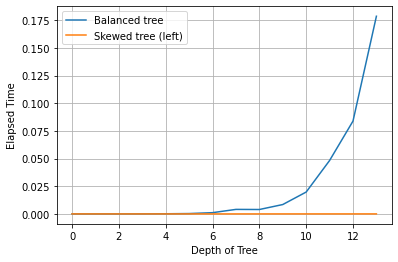

In [70]:
plt.plot(balanced_time, label="Balanced tree")
plt.plot(skewed_time, label="Skewed tree (left)")
plt.legend()
plt.grid()
plt.xlabel("Depth of Tree")
plt.ylabel("Elapsed Time")